# Figure 1
all data assumed to be in ../../data

## setup and load data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import ks_2samp, pearsonr, linregress

from rna_secstruct import SecStruct

from dms_3d_features.plotting import plot_pop_avg_from_row, plot_motif_boxplot_stripplot, publication_style_ax, plot_scatter_w_best_fit_line

plt.rcParams['figure.dpi'] = 300


In [2]:
def normalize(column):
    return (column - column.min()) / (column.max() - column.min())

def r2(x, y):
    return pearsonr(x, y)[0] ** 2

In [3]:
DATA_PATH = "../../data"

In [4]:
df = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1_combined.json")
df_2 = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_2_combined.json")
df_motif = pd.read_json(f"{DATA_PATH}/raw-jsons/motifs/pdb_library_1_motifs_standard.json")
df_residue = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")

In [5]:
df_residue["ln_r_data"] = np.log(df_residue["r_data"])
df_residue['ln_r_data'].replace(-np.inf, -9.8, inplace=True)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## plot data

### construct to highlight diversity of structures. Find one with the most different motifs

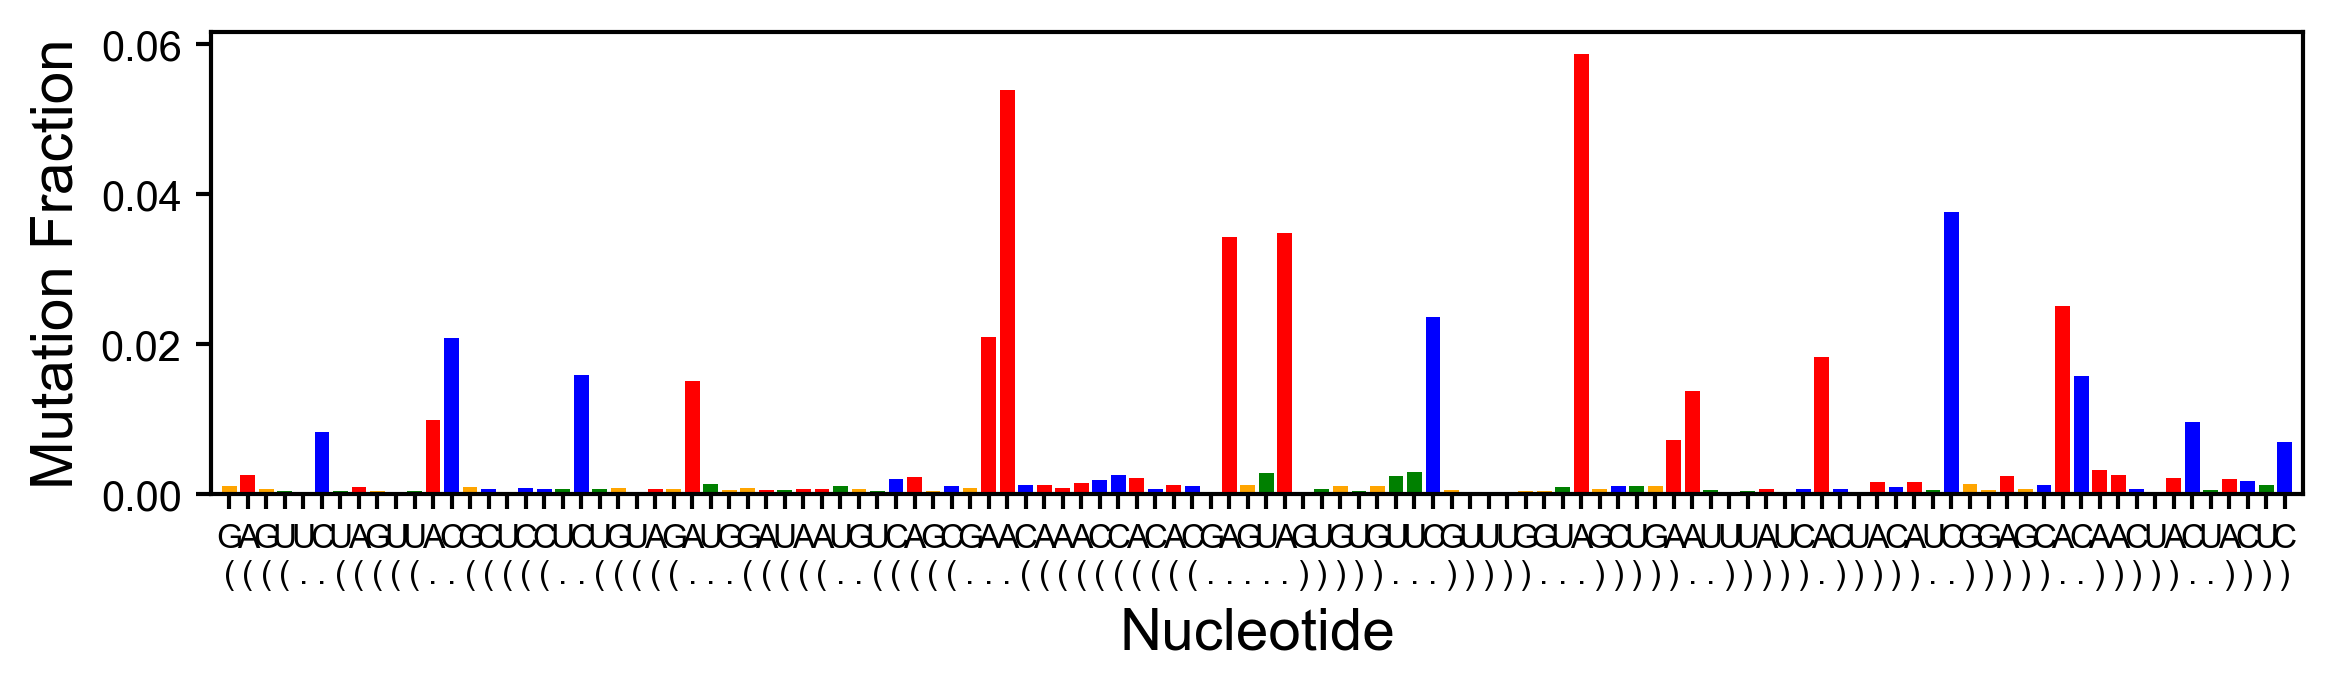

In [6]:
row = df.iloc[7000].to_dict()
row["sequence"] = row["sequence"][1:]
row["structure"] = row["structure"][1:]
row["data"] = row["data"][1:]
fig, ax = plt.subplots(figsize=(9.00, 2.0))
ax = plot_pop_avg_from_row(row, ax=ax)
ax.set_xlabel("Nucleotide")
ax.set_ylabel("Mutation Fraction")
ax.set_xlim(-1, 112)
publication_style_ax(ax, xtick_size=8)

### plot reproducibility

In [7]:
df_2_sub = df_2[["name", "data"]].copy()
df_2_sub.rename(columns={"data": "data_2"}, inplace=True)
df_merge = df.merge(df_2_sub, on="name")
print(df_merge.iloc[0])

name                                                construct750
sequence       AGACUACCCAUAAAGGUUAUUGCGAGCUAUUAAACGUCCACAGUUA...
structure      .((((..(((((..(((((..(((((..(((((..(((((..((((...
data           [0.00523, 0.00124, 0.0038, 0.00289, 0.00047000...
sn                                                         11.21
num_reads                                                  59978
num_aligned                                                59924
no_mut                                                     50.09
1_mut                                                      34.73
2_mut                                                      11.98
3_mut                                                       2.66
3plus_mut                                                   0.06
mfe                                                        -55.6
ens_defect                                                  0.62
data_2         [0.004390000000000001, 0.00239, 0.00288, 0.001...
Name: 0, dtype: object


In [26]:
data = []
for i, row in df_merge.iterrows():
    for d1, d2 in zip(row["data"], row["data_2"]):
        data.append({"data_1": d1, "data_2": d2})
df_data = pd.DataFrame(data)

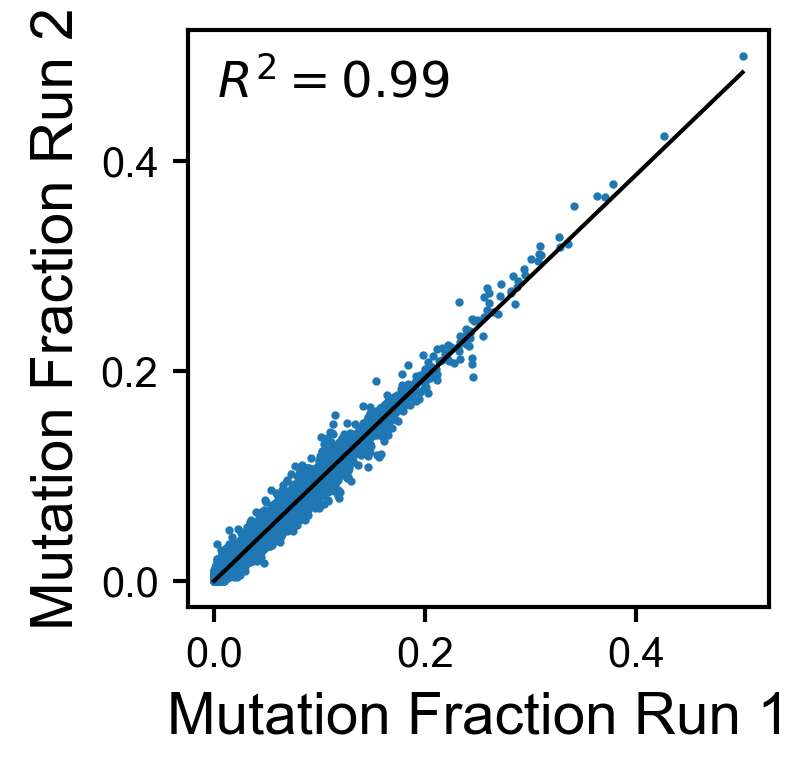

In [32]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
plot_scatter_w_best_fit_line(df_data["data_1"], df_data["data_2"], ax=ax)
ax.set_xlabel("Mutation Fraction Run 1")
ax.set_ylabel("Mutation Fraction Run 2")
publication_style_ax(ax)

### reactivity spread

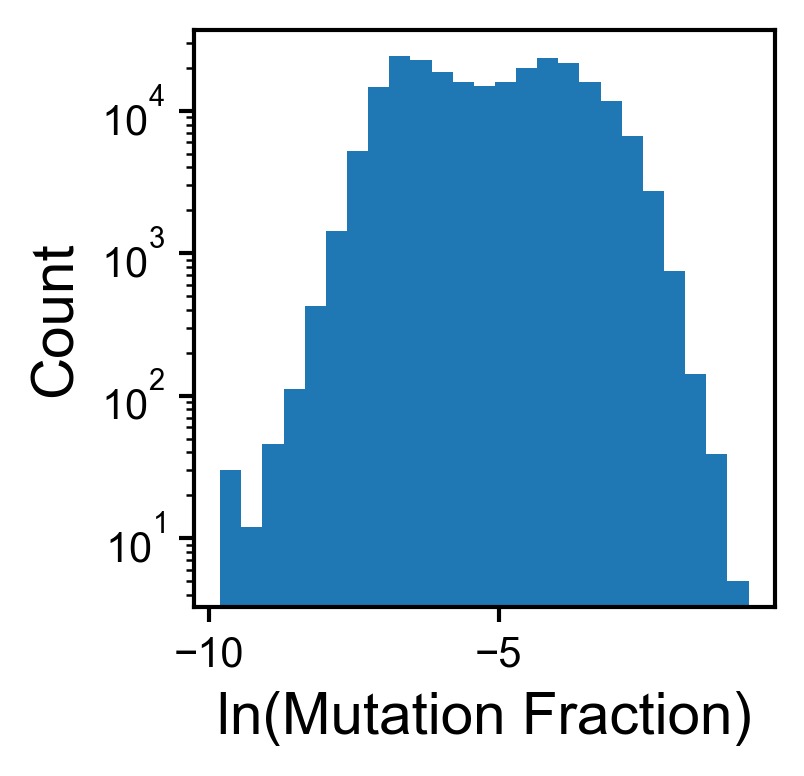

In [35]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.hist(df_residue['ln_r_data'], bins=25);
plt.yscale('log')
ax.set_xlabel("ln(Mutation Fraction)")
ax.set_ylabel("Count")
publication_style_ax(ax)

### motif count

In [11]:
data = []
for i, group in df_motif.groupby("m_sequence"):
    data.append([i, len(group)])
df_counts = pd.DataFrame(data, columns=["m_sequence", "count"])

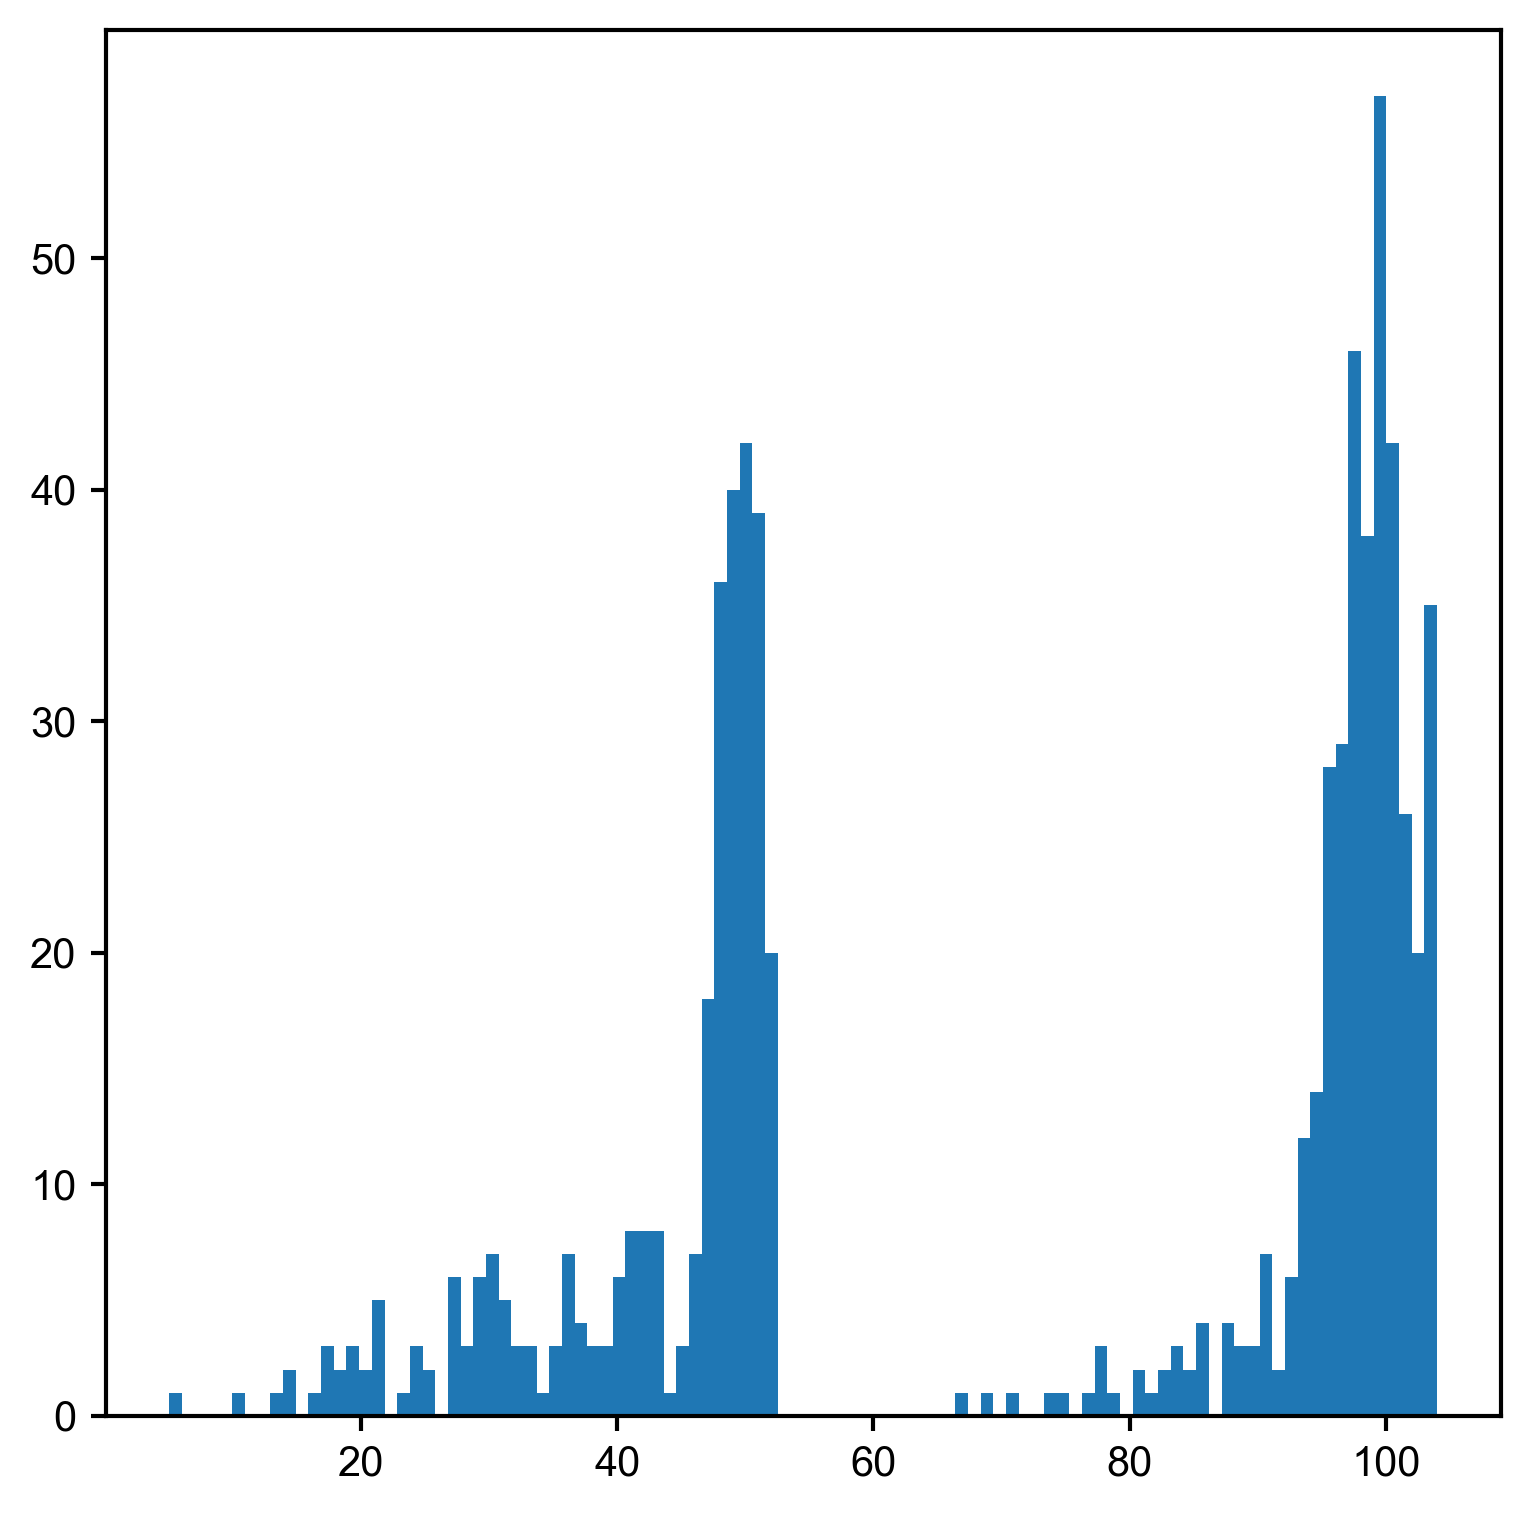

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.hist(df_counts["count"], bins=100);
publication_style_ax(ax)

### reactivity avg vs std

In [13]:
data = []
for i, group in df_residue.groupby(["r_loc_pos", "m_sequence"]):
    data.append([group["r_data"].mean(), group["r_data"].std()])
df_data = pd.DataFrame(data, columns=["mean", "std"])   

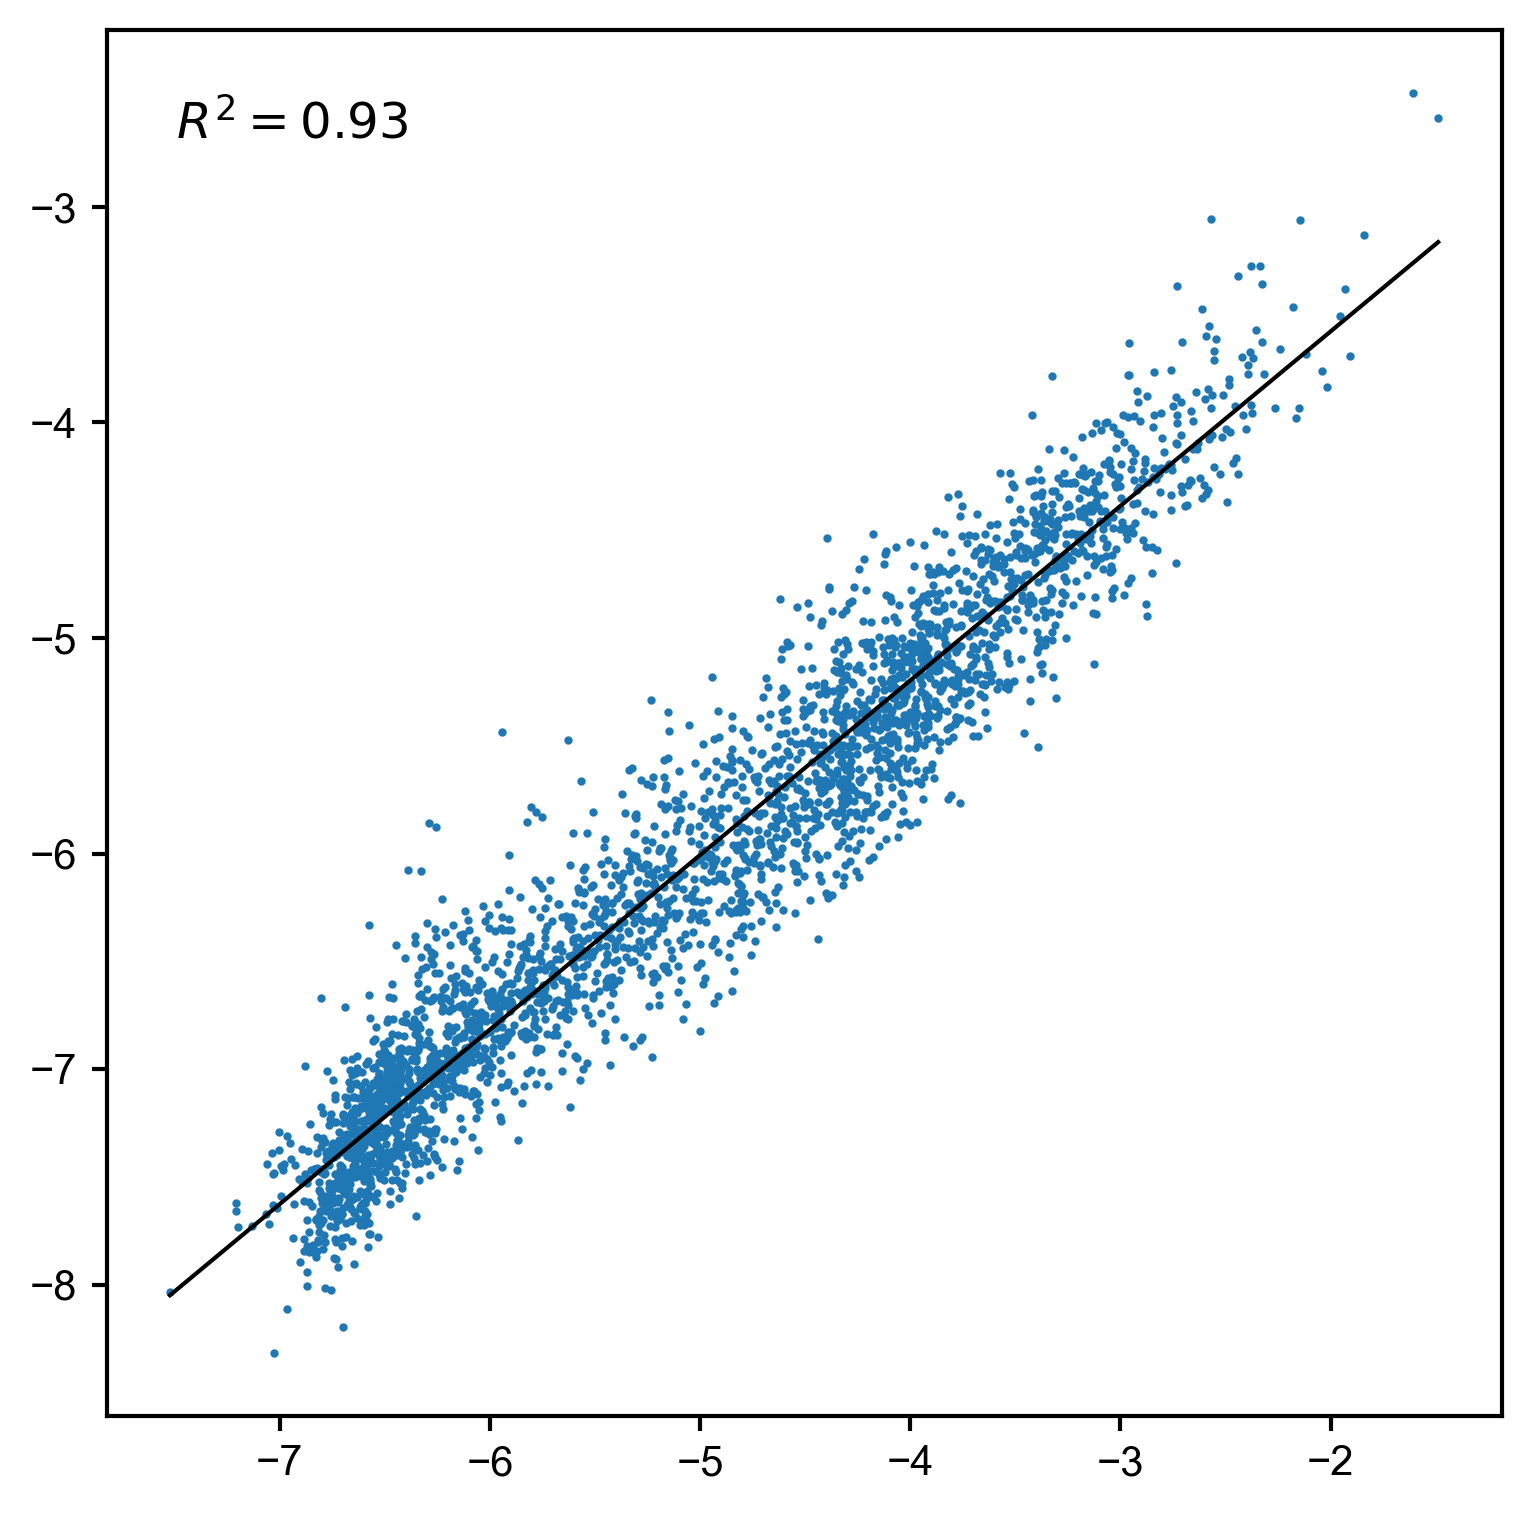

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_scatter_w_best_fit_line(np.log(df_data["mean"]), np.log(df_data["std"]), ax=ax)
publication_style_ax(ax)

In [15]:
r2(np.log(df_data["mean"]), np.log(df_data["std"]))

0.9307713605640217

In [16]:
data = []
for i, group in df_residue.groupby(["r_loc_pos", "m_sequence"]):
    std = group["r_data"].std()
    if std == 0:
        continue
    for _, row in group.iterrows():
        if row['r_data'] == 0:
            continue
        data.append([row["r_data"], std])
df_data = pd.DataFrame(data, columns=["r_data", "std"])   
df_data["ln_r_data"] = np.log(df_data["r_data"])

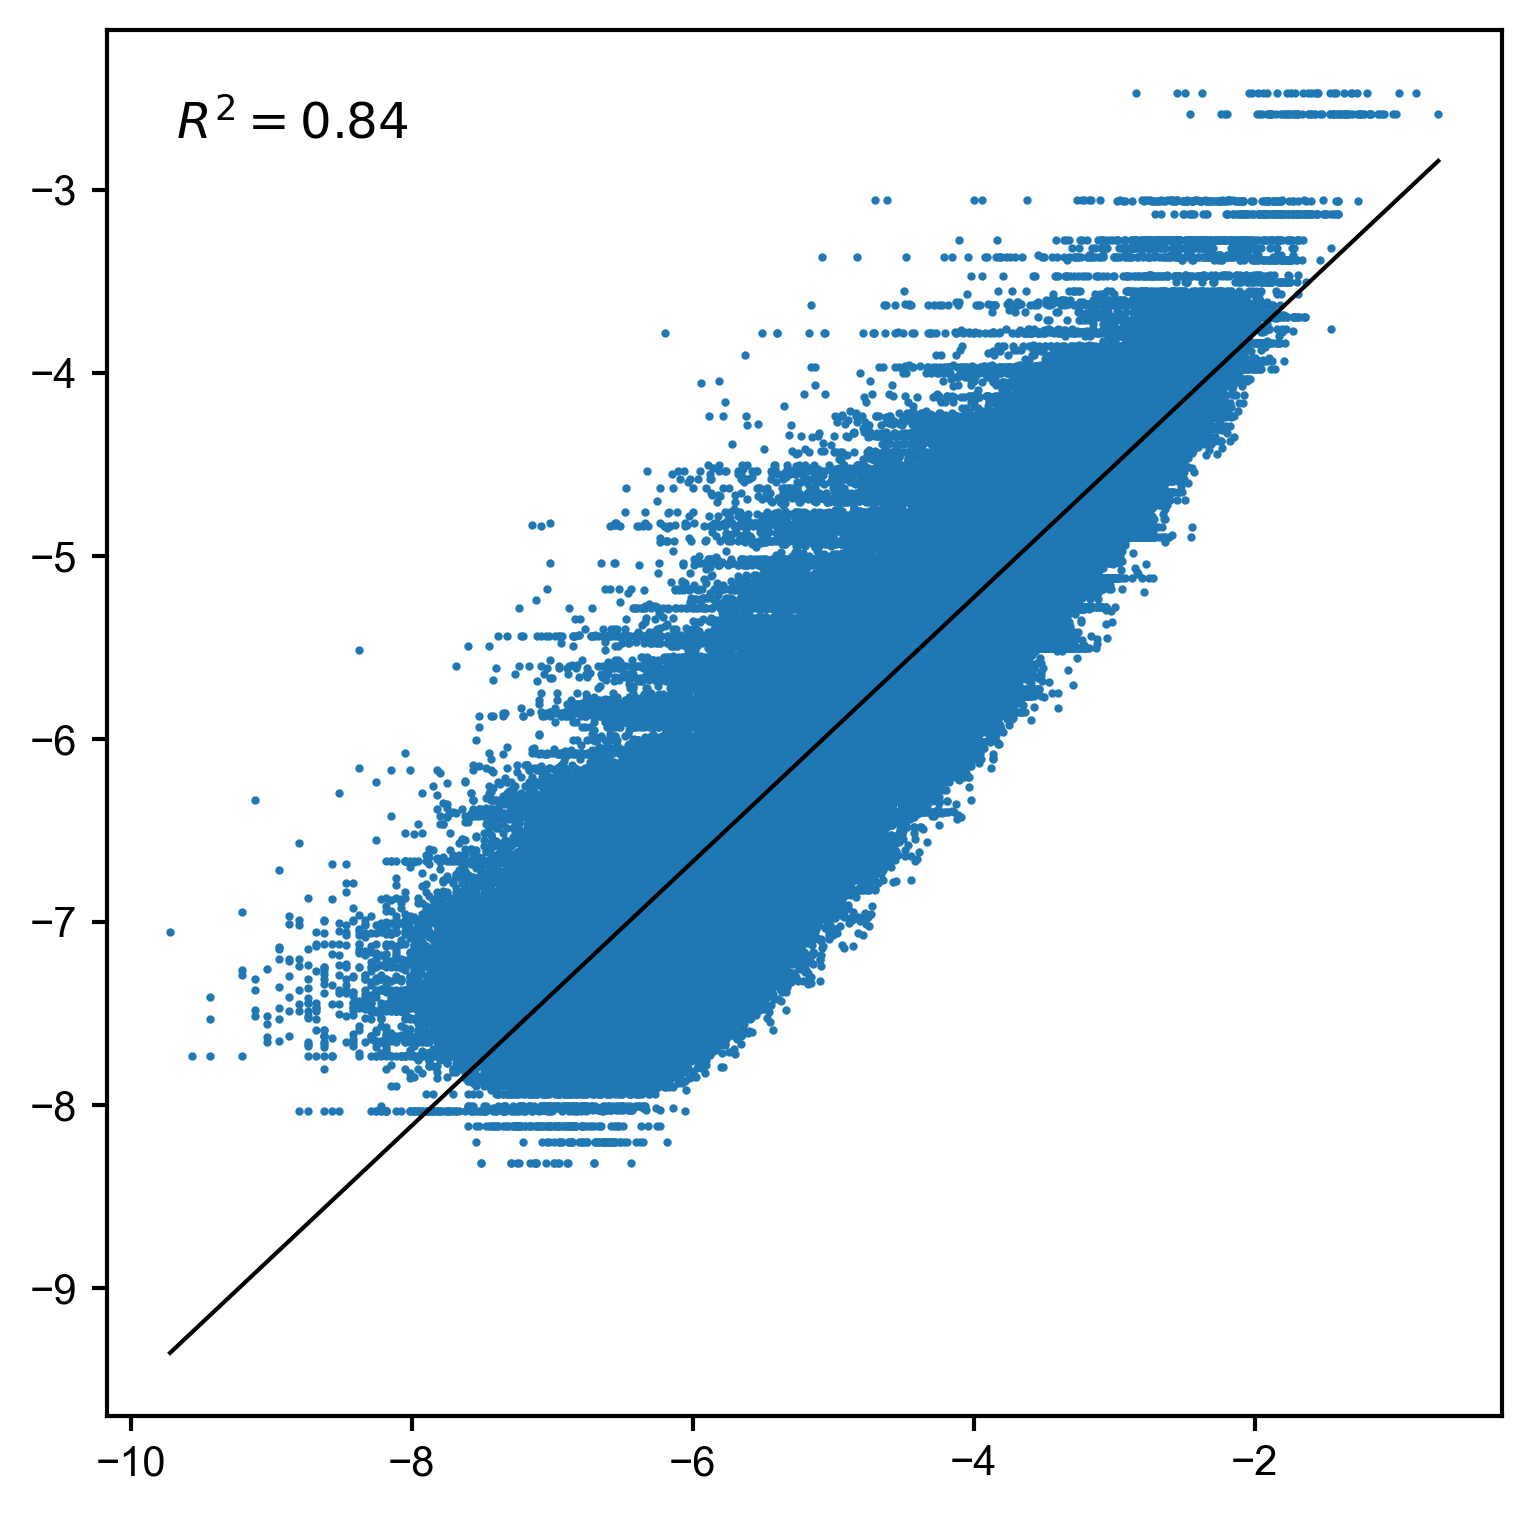

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_scatter_w_best_fit_line(np.log(df_data["r_data"]), np.log(df_data["std"]), ax=ax)
publication_style_ax(ax)

In [18]:
r2(np.log(df_data["r_data"]), np.log(df_data["std"]))

0.8425289665607527

### coefficient of variation

In [19]:
data = []
for i, group in df_residue.groupby(["r_loc_pos", "m_sequence"]):
    data.append(group["r_data"].std() / group["r_data"].mean())

In [20]:
np.mean(data)

0.3942839835926987

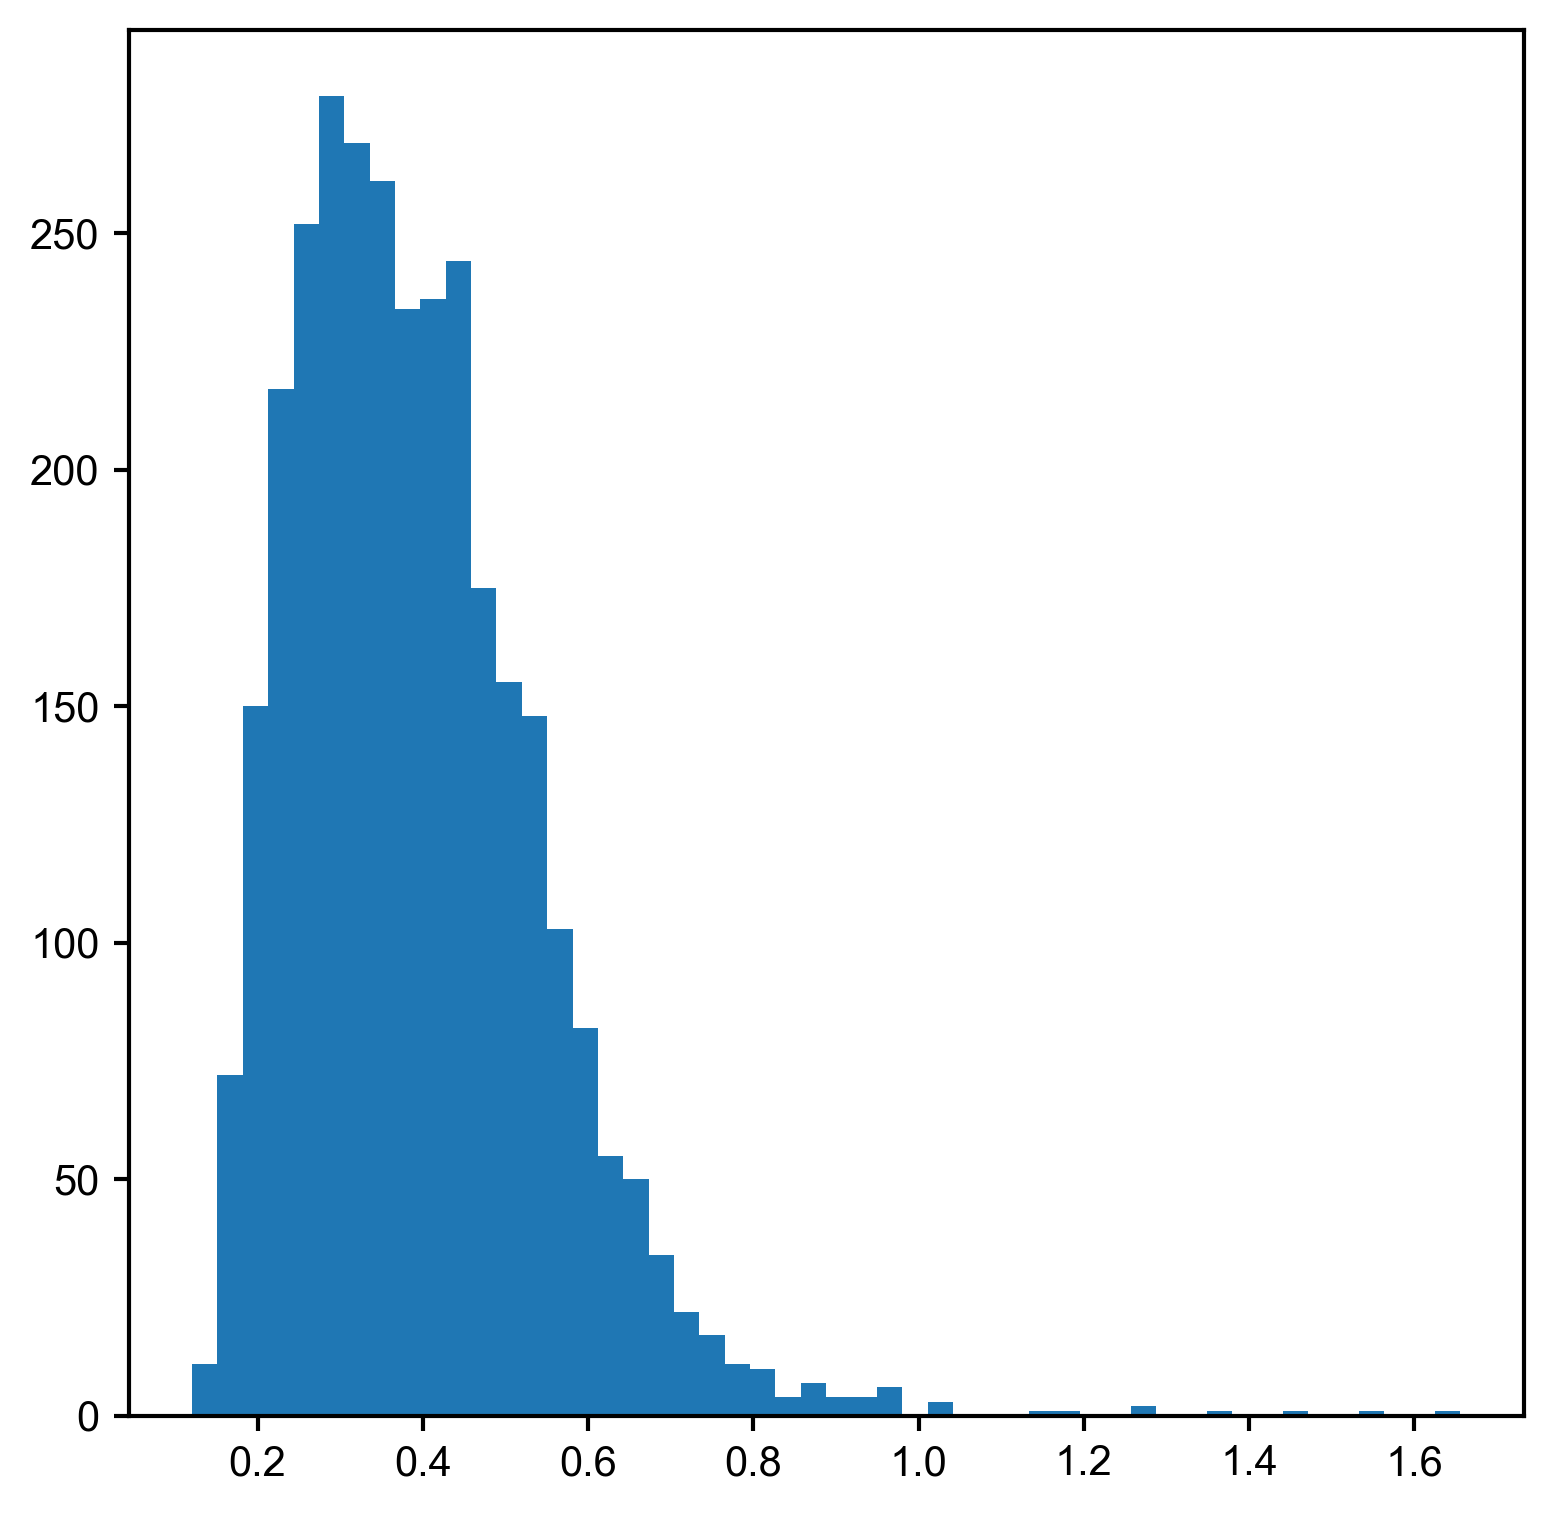

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.hist(data, bins=50)
publication_style_ax(ax)


### example motif

In [22]:
print(df_residue["m_sequence"].unique())   

['AAA&UAU' 'AAA&UCU' 'AAA&UGU' 'AAAA&UAAU' 'AAAA&UACU' 'AAAA&UAGU'
 'AAAA&UCAU' 'AAAA&UCGU' 'AAAA&UGAU' 'AAAA&UGGU' 'AAAC&GAAU' 'AAAC&GACU'
 'AAAC&GAGU' 'AAAC&GCAU' 'AAAC&GCGU' 'AAAC&GCU' 'AAAC&GGAU' 'AAAC&GGGU'
 'AAACG&CUAU' 'AAAG&CAAU' 'AAAG&CACU' 'AAAG&CAGU' 'AAAG&CCAU' 'AAAG&CCGU'
 'AAAG&CGAU' 'AAAG&CGGU' 'AAAGG&UACU' 'AAAU&AAAU' 'AAAU&AACU' 'AAAU&AAGU'
 'AAAU&ACAU' 'AAAU&ACGU' 'AAAU&AGAU' 'AAAU&AGGU' 'AAC&GAU' 'AAC&GCU'
 'AACA&UAAU' 'AACA&UACU' 'AACA&UCAU' 'AACA&UCCU' 'AACA&UUAU' 'AACA&UUCU'
 'AACC&GAAU' 'AACC&GACU' 'AACC&GCAU' 'AACC&GCCU' 'AACC&GUAU' 'AACC&GUCU'
 'AACG&CAAU' 'AACG&CACU' 'AACG&CCAU' 'AACG&CCCU' 'AACG&CUAU' 'AACG&CUCU'
 'AACG&CUGU' 'AACU&AACU' 'AACU&ACAU' 'AACU&ACCU' 'AACU&AUAU' 'AACU&AUCU'
 'AACU&AUGU' 'AAG&CAU' 'AAG&CCU' 'AAG&CGU' 'AAG&CU' 'AAGA&UAAU'
 'AAGA&UGAU' 'AAGC&GAAU' 'AAGC&GGAU' 'AAGCAG&UCAGGU' 'AAGG&CAAU'
 'AAGG&CGAU' 'AAGGAA&UGU' 'AAGU&AGAU' 'AAU&AAU' 'AAU&ACU' 'AAU&AGU'
 'AAU&GAU' 'AAUA&UCAU' 'AAUA&UCCU' 'AAUA&UUAU' 'AAUA&UUCU' 'AAUA&UUGU'
 'AAUC&GCAU

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:375: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


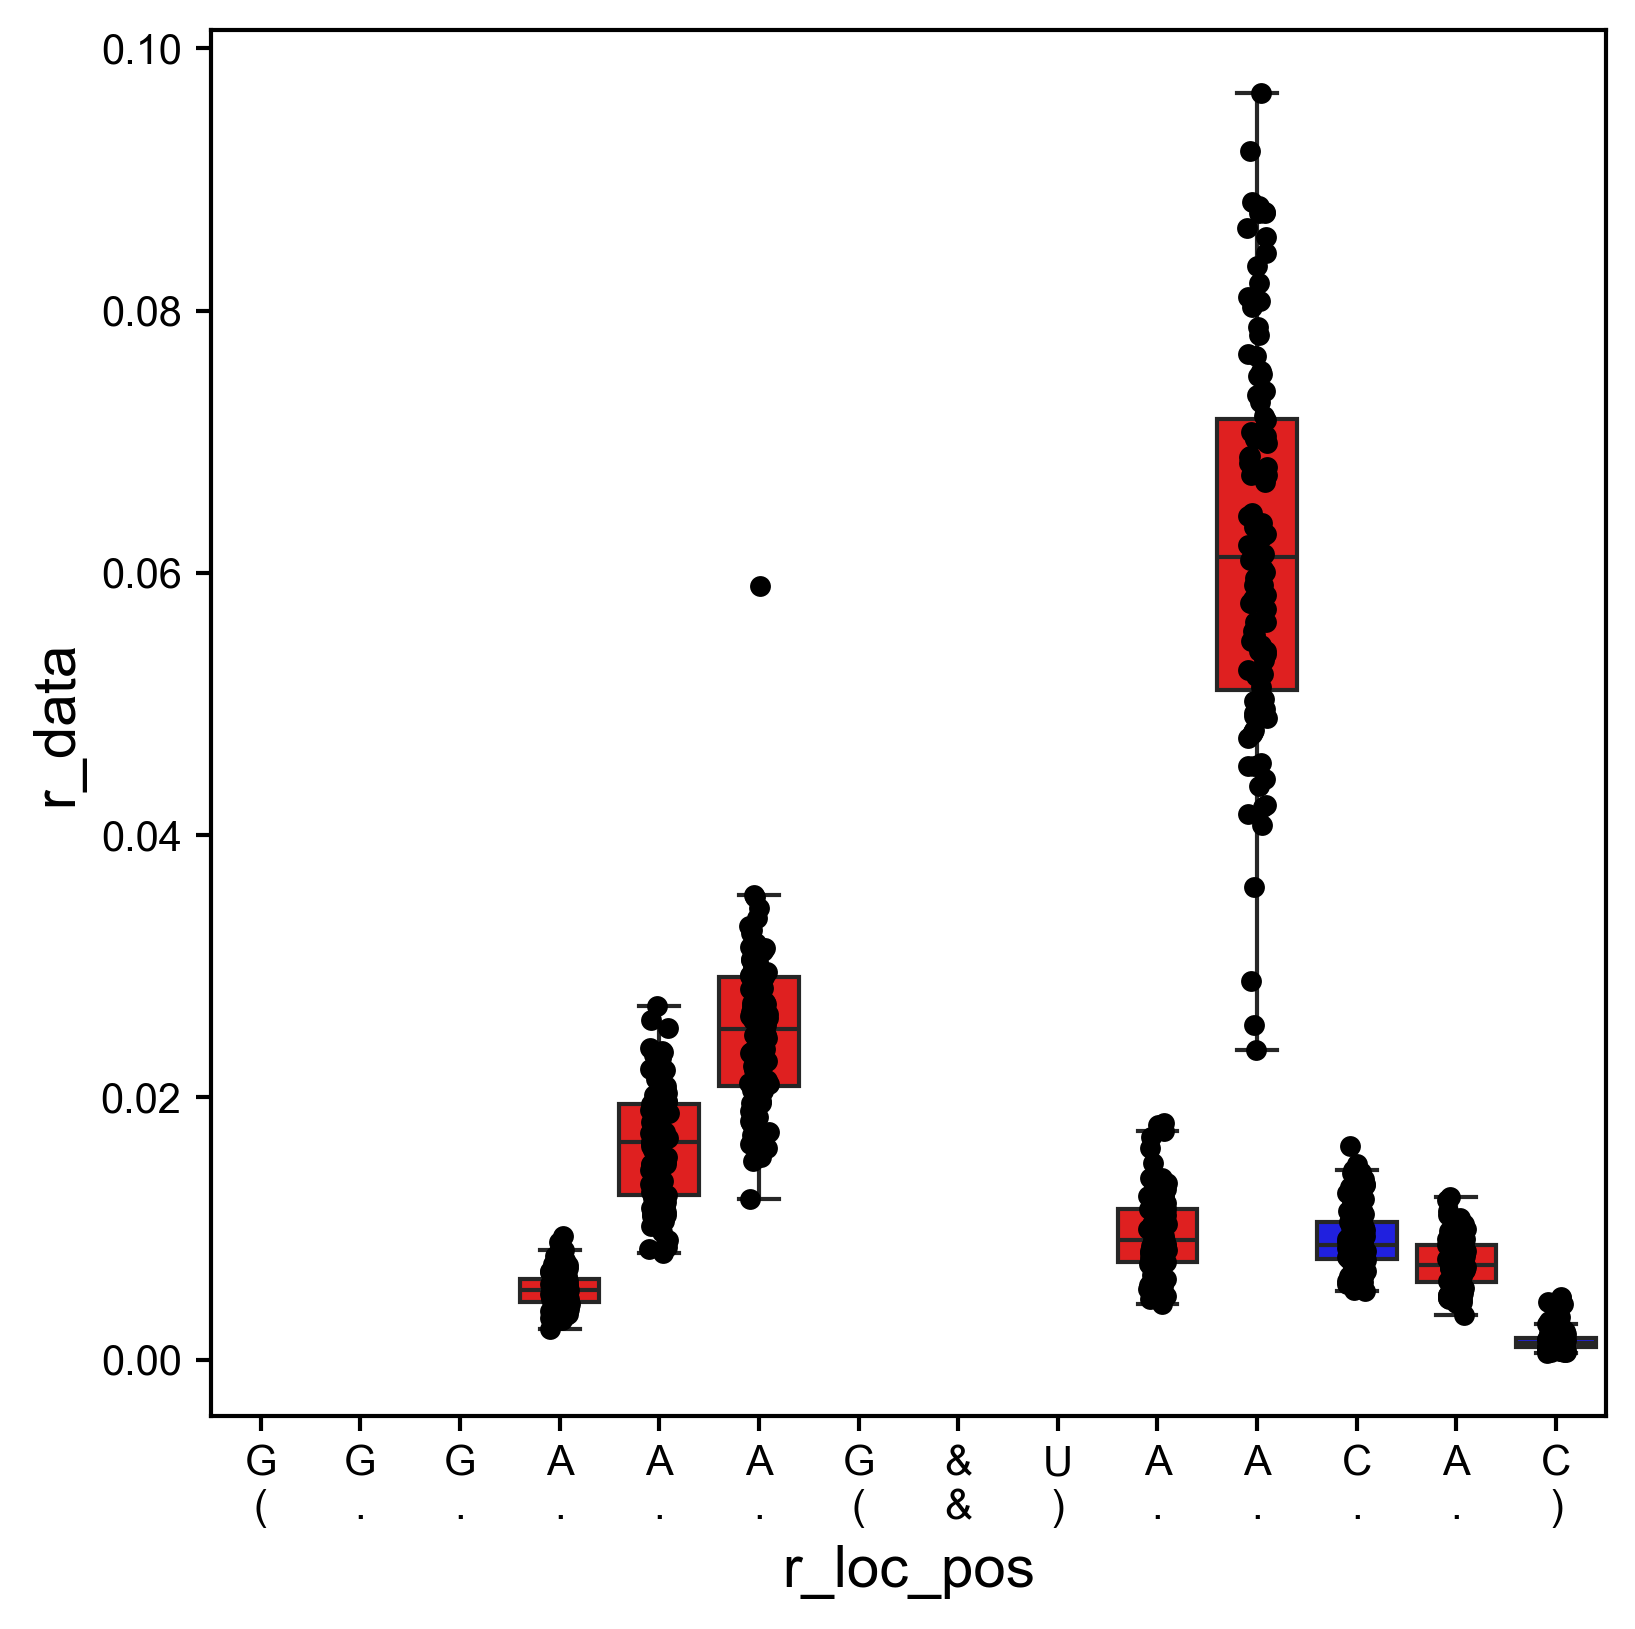

In [23]:
df_motif_example = df_residue[df_residue["m_sequence"] == "GGGAAAG&UAACAC"]
fig, ax = plt.subplots(figsize=(6, 6))
plot_motif_boxplot_stripplot(df_motif_example, ax=ax)
publication_style_ax(ax)